In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops
import math
import matplotlib.pyplot as plt
import time
import random

D:\abc\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Approach Description
The approach I used to solve this text classification challenge is based on the paper *Character-level Convolutional Networks for Text Classification*, published by Xiang ZHANG, Junbo ZHU, and Yann LECUN in 2016. In this project, text is treated as a kind of raw signal at character level, and one-dimensional ConvNets is applied on it. Therefore, this method does not require the knowledge about the syntactic or semantic structure of a language.<br>
<br>
Figure 1 describes the general process of the model. First of all, each line of text would be converted into a matrix with a size ($l$, $s$, 1) by using one-hot encoding, where $l$ represents the maximum length of a line of text in the training set, and $s$ represents the number of unique alphabets in the training set. Secondly, the matrix would be fed into a ConvNets model, and a output with a size of (1, 12) is expected to indicate the probability that this sample belonging to category 0-12 respectively. Finally, for each sample, the category with highest probability is selected as the predicted class of that sample.

<center><img src="images/CNN.jpg" style="width:650px;height:200px;"></center>
<center>Figure 1 Illustration of the model</center>
<br>
Reference: https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf

## Step1: Data Exploration and preprocessing

In [2]:
xtrain = open('xtrain_obfuscated.txt', 'r').read().split('\n')[:-1]
xtest = open('xtest_obfuscated.txt', 'r').read().split('\n')[:-1]
ytrain = open('ytrain.txt', 'r').read().split('\n')[:-1]

**Step 1.1 Check the number of unique alphabets in the training set **

In [3]:
data = open('xtrain_obfuscated.txt', 'r').read()
chars = list(set(data))
vocab_size = len(chars)
print('There are %d unique characters in your data.' % (vocab_size))

There are 27 unique characters in your data.


The characters are a-z (26 characters) plus the "\n", which indicates the end of a line of text. In the cell below, a python dictionary is created to map each character to an index from 0-26, which would be used to represent the column index each alphabet belong to in the input matrix.

In [4]:
char_to_ix = { ch:i for i,ch in enumerate(sorted(chars)) }
print(char_to_ix)

{'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


**Step 1.2 Check the maximum length of string in the training set **

In [5]:
max_seq_length = max([len(i) for i in xtrain])
print('The maximum length of string in your dataset is %d' % (max_seq_length))

The maximum length of string in your dataset is 452


**Step 1.3 Check the distribution of each class**

In [6]:
for i in range(0,12):
    print('number of value ' + str(i) + ':' + str(ytrain.count(str(i))))

number of value 0:543
number of value 1:3459
number of value 2:1471
number of value 3:4023
number of value 4:2337
number of value 5:2283
number of value 6:4226
number of value 7:5097
number of value 8:3634
number of value 9:980
number of value 10:3052
number of value 11:1408


The distribution of each class in the training set is relatively imbalanced, while the largest class (class 7) has 5097 samples, accounting for 15.68% of the training set, and the smallest class(class 0) has 543 samples, accounting for merely 1.67% of the training set. According to past experiment, distribution of the training data has a big impact on ConvNets performance. A relationship was found between larger imbalances and worse performances when some classes were over-represented. <br>
Reference: https://www.kth.se/social/files/588617ebf2765401cfcc478c/PHensmanDMasko_dkand15.pdf

Using the sampling technique oversampling on the imbalanced data increased the CNN performances to that of the ConvNets trained with balanced data. Therefore, a sampling method is adopted in this projected to mitigate this imbalance problem. Figure 2 shows the general strategy of balancing the dataset.
<center><img src="images/DataProcessing.png" style="width:700px;height:400px;"></center>
<center>Figure 2 Illustration of sampling</center>
<br>

Here, I want to generate a data set that each of the 12 categories has 4500 training samples and 500 validation samples respectively, so the total training set will have 54000 samples and validation set will have 6000 samples. To achieve it, samples with same label $i$ will be split into original training set(90%) and testing set(10%). If the size of original training set is larger than 4500, or the size of validation set is larger than 500, I will sample 4500 line of text from the original training set as new training set, and 500 line of text from the original validation set as new validation set. In contrast, if the size of original training set for a category is less than 4500, or the size of the original validation set is less than 500, an oversampling method would be adopted to generate new samples belonging to same class. Figure 3 depicts the method used to generate a new sample based on a random existing sample.
<center><img src="images/OverSampling.png" style="width:650px;height:250px;"></center>
<center>Figure 3 Illustration of oversampling</center>

In [7]:
def sampling(category, training_size, testing_size):
    x_train_sub = []
    y_train_sub = []
    x_valid_sub = []
    y_valid_sub = []

    index = [pos for pos, value in enumerate(ytrain) if value == str(category)]
    number = len(index)
    train_size = round(number * 0.9)

    train_idx = random.sample(index, train_size)
    valid_idx = [ele for ele in index if ele not in train_idx]
 

    if (number < (training_size + testing_size)):
    
        x_train_sub = x_train_sub + [value for pos, value in enumerate(xtrain) if pos in train_idx]
        x_valid_sub = x_valid_sub + [value for pos, value in enumerate(xtrain) if pos in valid_idx]
    
        num_of_increase_training = training_size - len(train_idx)
    
        for i in range(0, num_of_increase_training):
            sample_idx = random.sample(train_idx, 1)[0]
            sample = xtrain[sample_idx]
    
            start_point = random.sample(range(0, int(len(sample)/2)), 1)[0]
            end_point = random.sample(range(start_point + int(len(sample)/2), len(sample)), 1)[0]
            new_sample = [sample[start_point: end_point]]
            x_train_sub = x_train_sub + new_sample
        
        num_of_increase_valid = testing_size - len(valid_idx)
    
        for i in range(0, num_of_increase_valid):
            sample_idx = random.sample(valid_idx, 1)[0]
            sample = xtrain[sample_idx]
    
            start_point = random.sample(range(0, int(len(sample)/2)), 1)[0]
            end_point = random.sample(range(start_point + int(len(sample)/2), len(sample)), 1)[0]
            new_sample = [sample[start_point: end_point]]
            x_valid_sub = x_valid_sub + new_sample    

    else:
        train_idx = random.sample(train_idx, training_size)
        valid_idx = random.sample(valid_idx, testing_size)
    
        x_train_sub = x_train_sub + [value for pos, value in enumerate(xtrain) if pos in train_idx]
        x_valid_sub = x_valid_sub + [value for pos, value in enumerate(xtrain) if pos in valid_idx] 

    
    y_train_sub = [category for i in range(0, training_size)]
    y_valid_sub = [category for i in range(0, testing_size)]
    
    return x_train_sub, x_valid_sub, y_train_sub, y_valid_sub
    


In [8]:
training_size = 4500
testing_size = 500
x_train = []
x_valid = []
y_train = []
y_valid = []

for category in range(0,12):
    x_train_sub, x_valid_sub, y_train_sub, y_valid_sub = sampling(category, training_size, testing_size)
    x_train = x_train + x_train_sub
    x_valid = x_valid + x_valid_sub
    y_train = y_train + y_train_sub
    y_valid = y_valid + y_valid_sub

In [9]:
print("number of samples in x_train:" + str(len(x_train)))
print("number of samples in x_valid:" + str(len(x_valid)))
print("number of samples in y_train:" + str(len(y_train)))
print("number of samples in y_valid:" + str(len(y_valid)))


number of samples in x_train:54000
number of samples in x_valid:6000
number of samples in y_train:54000
number of samples in y_valid:6000


** Step 1.4 Convert text into matrix ** <br>
As the maximum length of text in the training set is 452, and the number of unique alphabets in the training set is 27, each line of text will be converted into a matrix with size (452, 27, 1), as shown in Figure 4.
<center><img src="images/matrix1.png" style="width:400px;height:200px;"></center>
<center>Figure 4 Illustration of encoding text</center>

In [10]:
def X_one_hot(data, vocab, seq_length):
    
    X_train = np.zeros(shape=[len(data), seq_length, len(vocab), 1])
    
    for i in range(0, len(data)):
        ith_seq = data[i]

        if (len(ith_seq) < seq_length):
            ith_seq = ith_seq + ('\n' * (seq_length - len(ith_seq)))
        else:
            ith_seq = ith_seq[0:(seq_length-1)]
        
        for j in range(0, len(ith_seq)):
            X_train[i][j][char_to_ix[ith_seq[j]]][0] = 1
    
    return X_train

In [11]:
def y_one_hot(labels, num_of_classes):
    
    num_of_classes = tf.constant(num_of_classes, name='num_of_classes')
    one_hot_matrix = tf.one_hot(indices=labels, depth=num_of_classes, axis=0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    
    return one_hot

In [12]:
X_train = X_one_hot(x_train, chars, max_seq_length)
X_valid = X_one_hot(x_valid, chars, max_seq_length)
X_test = X_one_hot(xtest, chars, max_seq_length)

y_train = y_one_hot(y_train, num_of_classes = 12).T
y_valid = y_one_hot(y_valid, num_of_classes = 12).T


print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_validation shape: " + str(X_valid.shape))
print ("y_validation shape: " + str(y_valid.shape))
print ("X_test shape: " + str(X_test.shape))

number of training examples = 54000
number of test examples = 3000
X_train shape: (54000, 452, 27, 1)
y_train shape: (54000, 12)
X_validation shape: (6000, 452, 27, 1)
y_validation shape: (6000, 12)
X_test shape: (3000, 452, 27, 1)


## Step2: Create Placeholder

In [13]:
def create_placeholders(n_H0, n_W0, n_y):

    X = tf.placeholder(tf.float32, shape = [None, n_H0, n_W0, 1], name = 'input_x')
    Y = tf.placeholder(tf.float32, [None, n_y], name = 'input_y')
    dropout_keep_prob = tf.placeholder(tf.float32, name = 'dropout_keep_prob')
    
    return X, Y, dropout_keep_prob

In [14]:
X, Y, dropout_keep_prob = create_placeholders(max_seq_length, vocab_size,n_y = 12)
print ("X = " + str(X))
print ("Y = " + str(Y))
print ("Dropout_keep_prob = " + str(dropout_keep_prob))

X = Tensor("input_x:0", shape=(?, 452, 27, 1), dtype=float32)
Y = Tensor("input_y:0", shape=(?, 12), dtype=float32)
Dropout_keep_prob = Tensor("dropout_keep_prob:0", dtype=float32)


## Step3: Define a function for forward propagation
Due to the time and resource constraint, the ConvNets model contains 5 layers, with 3 convolutional layers and 2 fully-connected layers. The convolutional layers have stride 1 and pooling layers are all non-overlapping. The details of each layer is shown in following tables.<br>
<br>
<center>Table 1: Convolutional layers description</center><br>
<center><img src="images/ConvLayer.png" style="width:500px;height:120px;"></center>
<br>
<center>Table 2: Fully-connected layers description</center><br>
<center><img src="images/FullyConnectedLayer2.png" style="width:400px;height:80px;"></center>

Code in the following cell refers to: https://github.com/lc222/char-cnn-text-classification-tensorflow/blob/master/char_cnn.py

In [15]:
def forward_propagation(X, n_y, dropout_keep_prob):
    conv_layers = [
                    [256, 7, 3],
                    #[256, 7, 3],
                    #[256, 3, None],
                    #[256, 3, None],
                    [256, 3, None],
                    [256, 3, 3]]
                    

    fully_layers = [1024]
    
    var_id = 0
    
    parameters = {}
    
    # Convolution layer
    for i, cl in enumerate(conv_layers):
        var_id += 1 
        filter_width = X.get_shape()[2].value
        filter_shape = [cl[1], filter_width, 1, cl[0]] # Perform 1D conv with [kw, inputFrameSize (i.e alphabet_size), outputFrameSize]
        stdv = 1/np.sqrt(cl[0]*cl[1])
        W = tf.Variable(tf.random_uniform(filter_shape, minval=-stdv, maxval=stdv), dtype='float32', name='W'+ str(var_id) ) # The kernel of the conv layer is a trainable vraiable
        b = tf.Variable(tf.random_uniform(shape=[cl[0]], minval=-stdv, maxval=stdv), name = 'b' + str(var_id)) # and the biases as well
        parameters['W' + str(var_id)] = W
        parameters['b' + str(var_id)] = b

        conv = tf.nn.conv2d(X, W, [1, 1, 1, 1], "VALID", name = "Conv") # Perform the convolution operation

        X = tf.nn.bias_add(conv, b)

        if not cl[-1] is None:
            pool = tf.nn.max_pool(X, ksize=[1, cl[-1], 1, 1], strides=[1, cl[-1], 1, 1], padding='VALID')
            X = tf.transpose(pool, [0, 1, 3, 2]) 
        else:
            X = tf.transpose(X, [0, 1, 3, 2], name='tr%d' % var_id)

    vec_dim = X.get_shape()[1].value * X.get_shape()[2].value
    X = tf.reshape(X, [-1, vec_dim])
    weights = [vec_dim] + list(fully_layers)
    
    # Fully-connected layer
    for i, fl in enumerate(fully_layers):
        var_id += 1
        stdv = 1/np.sqrt(weights[i])
        W = tf.Variable(tf.random_uniform([weights[i], fl], minval=-stdv, maxval=stdv), dtype='float32', name='W')
        b = tf.Variable(tf.random_uniform(shape=[fl], minval=-stdv, maxval=stdv), dtype='float32', name = 'b')
        parameters['W' + str(var_id)] = W
        parameters['b' + str(var_id)] = b
                
        X = tf.nn.xw_plus_b(X, W, b)
        X = tf.nn.dropout(X, dropout_keep_prob)
    
    stdv = 1/np.sqrt(weights[-1])
    W = tf.Variable(tf.random_uniform([weights[-1], n_y], minval=-stdv, maxval=stdv), dtype='float32', name='W')
    b = tf.Variable(tf.random_uniform(shape=[n_y], minval=-stdv, maxval=stdv), name = 'b')
    parameters['W' + str(var_id + 1)] = W
    parameters['b' + str(var_id + 1)] = b
    p_y_given_x = tf.nn.xw_plus_b(X, W, b, name="scores")
        
    return p_y_given_x, parameters

In [16]:
#tf.reset_default_graph()

with tf.Session() as sess:
    X, Y, dropout_keep_prob = create_placeholders(max_seq_length, vocab_size,n_y = 12)
    p_y_given_x = forward_propagation(X, 12, dropout_keep_prob)
    sess.run(tf.global_variables_initializer())
    res1, res2 = sess.run(p_y_given_x, {X: np.random.randn(2,452,27,1), dropout_keep_prob:0.5})
    print("p_y_given_x = " + str(res1))
    #print(res2)


p_y_given_x = [[ 0.05735406  0.02709517  0.01198866  0.03233381  0.00304832 -0.03089858
  -0.00684476  0.00375878 -0.01954173  0.03440209 -0.01253452  0.05587472]
 [-0.00113846  0.01628569 -0.0179968  -0.00666194  0.0297815  -0.01148325
   0.01343633  0.00485595 -0.03527058  0.00794092 -0.00568362  0.06436133]]


## Step4: Define a function to compute cost

In [18]:
def compute_cost(X, Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=X, labels=Y))
    
    return cost

In [19]:
#tf.reset_default_graph()

with tf.Session() as sess:
    X, Y, dropout_keep_prob = create_placeholders(max_seq_length, vocab_size,n_y = 12)
    p_y_given_x, parameters = forward_propagation(X, 12, dropout_keep_prob)
    cost = compute_cost(p_y_given_x, Y)
    sess.run(tf.global_variables_initializer())
    res2 = sess.run(cost, {X: np.random.randn(2,452,27,1), dropout_keep_prob:0.5, Y: np.random.randint(0, 11, size = (2,12))})
    print("cost = " + str(res2))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

cost = 140.47882


## Step5: Define a function to divide mini batches

In [20]:
def random_mini_batches(X, Y, mini_batch_size):

    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:(k + 1) * mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [21]:
mini_batches = random_mini_batches(X_train, y_train, 64)

print("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
#print("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (64, 452, 27, 1)
shape of the 2nd mini_batch_X: (64, 452, 27, 1)
shape of the 3rd mini_batch_X: (64, 452, 27, 1)
shape of the 1st mini_batch_Y: (64, 12)
shape of the 2nd mini_batch_Y: (64, 12)
shape of the 3rd mini_batch_Y: (64, 12)


## Step6：Modelling
Parameters of this model include:
- learning rate = 0.0001
- number of epochs = 120
- minibatch_size = 1024
- drop out probibility = 0.5


In [22]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001,
          num_epochs=120, minibatch_size=1024, print_cost=True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []    
    conv_layers = [
                    [256, 7, 3],
                    #[256, 7, 3],
                    #[256, 3, None],
                    #[256, 3, None],
                    [256, 3, None],
                    [256, 3, 3]
                    ]

    fully_layers = [1024]
    # Create Placeholders of the correct shape
    X, Y, dropout_keep_prob = create_placeholders(n_H0, n_W0, n_y)

    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    p_y_given_x, parameters = forward_propagation(X, n_y, dropout_keep_prob)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(p_y_given_x, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set

            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
    
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y,dropout_keep_prob:[0.5]})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
            if minibatch_cost < 0.01:
                break
                
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        predict_op = tf.argmax(p_y_given_x, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, dropout_keep_prob: 0.5})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test, dropout_keep_prob: 0.5})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 2.394825
Cost after epoch 5: 1.968447
Cost after epoch 10: 1.592282
Cost after epoch 15: 1.296215
Cost after epoch 20: 1.142729
Cost after epoch 25: 1.026083
Cost after epoch 30: 0.941631
Cost after epoch 35: 0.870623
Cost after epoch 40: 0.789543
Cost after epoch 45: 0.719298
Cost after epoch 50: 0.661522
Cost after epoch 55: 0.614659
Cost after epoch 60: 0.555133
Cost after epoch 65: 0.498714
Cost after epoch 70: 0.451806
Cost after epoch 75: 0.406383
Cost after epoch 80: 0.347689
Cost after epoch 85: 0.317224
Cost after epoch 90: 0.275441
Cost after epoch 95: 0.229052
Cost after epoch 100: 0.185574
Cost after epoch 105: 0.156622
Cost after epoch 110: 0.121651
Cost after epoch 115: 0.097044


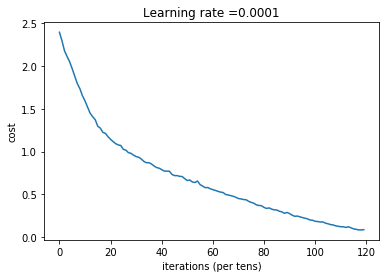

Train Accuracy: 0.98205554
Test Accuracy: 0.64966667
Time used: 24716.676879426468


In [23]:
start = time.clock()
_, _, parameters = model(X_train, y_train, X_valid, y_valid)
elapsed = (time.clock() - start)
print("Time used:",elapsed)

## Step7: Prediction

In [24]:
def forward_propagation_for_predict(X, parameters, dropout_keep_prob):

    conv_layers = [
                    [256, 7, 3],
                    #[256, 7, 3],
                    #[256, 3, None],
                    #[256, 3, None],
                    [256, 3, None],
                    [256, 3, 3]]
                    

    fully_layers = [1024]
    
    var_id = 0
        
    for i, cl in enumerate(conv_layers):
        var_id += 1

        W = params["W" + str(var_id)]
        b = params["b" + str(var_id)]

        conv = tf.nn.conv2d(X, W, [1, 1, 1, 1], "VALID", name = "Conv") # Perform the convolution operation

        X = tf.nn.bias_add(conv, b)

        if not cl[-1] is None:
            pool = tf.nn.max_pool(X, ksize=[1, cl[-1], 1, 1], strides=[1, cl[-1], 1, 1], padding='VALID')
            X = tf.transpose(pool, [0, 1, 3, 2]) 
        else:
            X = tf.transpose(X, [0, 1, 3, 2], name='tr%d' % var_id)

    vec_dim = X.get_shape()[1].value * X.get_shape()[2].value
    X = tf.reshape(X, [-1, vec_dim])
    weights = [vec_dim] + list(fully_layers)
    
    for i, fl in enumerate(fully_layers):
        var_id += 1

        W = params["W" + str(var_id)]
        b = params["b" + str(var_id)]
                
        X = tf.nn.xw_plus_b(X, W, b)
        X = tf.nn.dropout(X, dropout_keep_prob)
    
    W = params["W" + str(var_id + 1)]
    b = params["b" + str(var_id + 1)]


    p_y_given_x = tf.nn.xw_plus_b(X, W, b, name="scores")  
    
    return p_y_given_x

In [25]:
def predict(X, parameters):
    
    params = {}
    
    for key in parameters.keys():
        params[key] = tf.convert_to_tensor(parameters[key])

        
    x = tf.placeholder(tf.float32, shape = [None, 452, 27, 1], name = 'input_x')
    dropout_keep_prob = tf.placeholder(tf.float32, name = 'dropout_keep_prob')      

    predictions = forward_propagation_for_predict(x, params, dropout_keep_prob)

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        predictions = sess.run(predictions, feed_dict = {x: X, dropout_keep_prob:0.5})
        predicted_value = tf.argmax(predictions,1)
    
    
    return predicted_value

In [26]:
predicted_value = predict(X_test, parameters)


In [27]:

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables()) #execute init_op
    #print the random values that we sample
    res = sess.run(predicted_value)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [28]:
np.savetxt('ytest_v10.txt', res, fmt='%.1d')